Download tess qlp data for angela santos catalog, then run lobster pipeline, then run rooster pipeline

In [ ]:
import sys
import matplotlib.pyplot as plt
import star_privateer as sp
import numpy as np
import pandas as pd
import os
from PIL import Image

import ipad
from ipad.downloads import kadacs
from ipad.io import reader
from ipad.plotting import standard_plt
import ipad.calculation as cal
from ipad.catalog import Catalog

sys.path.append("../")
plt.ioff()

import lobster
from lobster.filtering import sin4_filter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def standard_plt():

    # import matplotlib.pyplot as plt

    label_size = 15
    plt.rcParams["xtick.labelsize"] = label_size
    plt.rcParams["ytick.labelsize"] = label_size
    plt.rcParams["axes.labelsize"] = label_size + 2

    params = {
        "legend.fontsize": label_size,
        "figure.figsize": (15, 5),
        "axes.labelsize": label_size,
        "axes.titlesize": "x-medium",
        "xtick.labelsize": label_size,
        "ytick.labelsize": label_size,
    }
    plt.rcParams.update(params)

    # figure_dir='/home/dinilbose/Desktop/Work/Cluster/NGC_2477/documents/Final/ALL_figures/'

    import warnings

    warnings.filterwarnings("ignore")
    standard_plt()

### Data location with IPAD and LOAD list of stars

In [ ]:
cat = ipad.catalog.Catalog()
# cat.all_catalogs
data_loc_qlp = cat.load_data_location("local_dl_tess").file_location
# or like this if the data location was already loaded
# data_loc_qlp=cat.data_location.local_dl_kadacs.file_location
# cat.data_location.local_dl_tess.file_location
# load ohio catalog
ohio_data = cat.load_catalog("ohio_stars")
ohio_data = ohio_data.dropna(subset=["TIC"])
ohio_data["TIC"] = ohio_data.TIC.astype(int)
list_tic_stars = ohio_data["TIC"].tolist()
# Cross with QLP TESS data
catalog_manager = Catalog()
qlp_catalog = catalog_manager.load_catalog("QLP_target_list")
qlp_catalog.query("TIC == @list_tic_stars ")
# before merging to save time do a filter
tic_list = list_tic_stars
qlp_catalog_f = qlp_catalog.query("TIC == @tic_list")
qlp_catalog_f["qlp_available"] = 1
# qlp_catalog_f
dat_for_download = ohio_data.merge(qlp_catalog_f, on="TIC", how="outer")
dat_for_download = dat_for_download.dropna(subset=["Sector"])
dat_for_download = dat_for_download.dropna(subset=["TIC"])
# dat_for_download
print("Total number of stars with different sectors", len(dat_for_download))
print("Total number of unique stars", len(dat_for_download.TIC.unique()))
# Adding download url and download location for QLP data
dat_for_download["download_location"] = dat_for_download.apply(
    lambda row: ipad.downloads.qlp.get_star_qlp_directory(tic=row["TIC"], dest_dir=data_loc_qlp),
    axis=1,
)
dat_for_download["download_url"] = dat_for_download.apply(
    lambda row: ipad.downloads.qlp.get_http_fits_file(tic=row["TIC"], sector=row["Sector"]), axis=1
)
ipad.downloads.engine.v6_hybrid(
    dat_for_download,
    log_name="./test_files/test_download_ohio.txt",
    tqdm_update=1,
    check_existing_files=True,
    max_workers=20,
).download_files()
dat_for_download.to_parquet("Ohio_stars_for_analysis.parquet")

Configuration loaded from /home/aunetx/ipad_config/config_catalog.py
DBP_dl_4most_temp
Configuration loaded from /home/aunetx/ipad_config/config_catalog.py
Configuration loaded from /home/aunetx/ipad_config/config_catalog.py
DBP_dl_4most_temp
Configuration loaded from /home/aunetx/ipad_config/config_catalog.py


/tmp/ipykernel_98111/183534099.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ohio_data['TIC']=ohio_data.TIC.astype(int)
/tmp/ipykernel_98111/183534099.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qlp_catalog_f['qlp_available']=1


Total number of stars with different sectors 4654
Total number of unique stars 419


Engine: V6 hybrid: Distance covered (km): 100%|██████████| 4654/4654 [00:01<00:00, 3622.16m/s]


# CORRECTIONS 
### Reading QLP data and applying Lobster Correction for single star

### Definition of the needed functions for the loop (lobster functions) 

New Function (15th May)

In [ ]:
# 15th May Function
def process_single_star_single_filter(
    tic,
    flux_variable="SAP_FLUX",
    apply_big_gaps_removal=True,
    apply_filter=True,
    filter_size_days=60,
    data_loc_qlp=None,
    debug=False,
    path_name_out="./output_15May_test_",
    write_fits_file=True,
    save_fig=True,
    starprivateer=False,
    apply_equalization=False,
    min_sector=0,
    max_sector=0,
):
    # Defining variables
    # flux_variable = 'SYS_RM_FLUX'
    min_remove_big_gaps_longer_than_days = (
        3.0 * 27.0
    )  # Maximum number of sectors GAP. Above this numbers gap is removed; in days
    min_small_gaps_longer_than_days = (
        5 / 24
    )  # Every time gap longer than this are stitched => ************* Maybe 3h ******************
    max_small_gaps_longer_than_days = 3  # The maximum to be considered is the max gap limit
    min_number_isolated_points = 20  # Number of isolated points to be removed by isolated points function => ****** Should be in TIME (DAYS)*********
    cadence_days = 0.5 / 24  # Final Cadence of the LC
    threshold_1st_sigma_cliping = 10  # threshold first sigma cliping
    # threshold_2nd_sigma_cliping = 6 # threshold second sigma cliping
    # short_dual_filter_period_days = 3          # Dual filter parameters
    # threshold_second_factor_dual_filter = 0.2  # Dual filter parameters
    save_fits_dir = path_name_out + str(flux_variable) + "_" + str(filter_size_days) + "d/fits/"
    save_fig_dir = path_name_out + str(flux_variable) + "_" + str(filter_size_days) + "d/figs/"
    lobster_fig = save_fig_dir + "/lobster_fig/"
    combined_fig = save_fig_dir + "/combined_figure/"
    if save_fig:
        os.makedirs(save_fig_dir, exist_ok=True)
        os.makedirs(lobster_fig, exist_ok=True)
        os.makedirs(combined_fig, exist_ok=True)

    if write_fits_file:
        os.makedirs(save_fits_dir, exist_ok=True)

    # Reading files
    # -----------------------------------------------
    file_name_list = ipad.downloads.qlp.get_star_list_of_fits_file(tic, dest_dir=data_loc_qlp)
    source_df = ipad.io.reader.read_multiple_fits_files(file_name_list).to_pandas()
    source_df = source_df.sort_values("TIME")
    # print(source_df)
    source_df["SECTOR"] = source_df["SECTOR"].astype(int)
    if min_sector > 0:
        source_df = source_df.query("SECTOR > @min_sector")
    if max_sector > 0:
        source_df = source_df.query("SECTOR < @max_sector")
    time = source_df["TIME"].values
    flux = source_df[flux_variable].values
    quality = source_df["QUALITY"].values
    no_of_sector = len(source_df.SECTOR.unique())
    all_parameters = {"rotation_parameters": {}}

    if len(flux[~np.isnan(flux)] > 100):  # To verify minimum number of points to run
        lc = lobster.Lightcurve()
        lc.init_from_data(time.copy(), flux.copy(), quality=quality.copy(), jumps={})
        # # DO a copy of lc in lc1 ***** REMOVE
        # lc1 = lc.copy()
        # lc1.resample(cadence_days)

        # ----------- BAD QUALITY -----------------------
        # remove when Quality vector is not 0
        # -----------------------------------------------
        lc.remove_quality(removal_mode="NaN")
        # ------------ PLOT DEFINITION ------------------
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(8, 10), dpi=80)
        lc.debug = False
        lc.dpi = 80
        lc.plot_flux(ax=ax1, title="Flux Original Quality - NaN")
        # ------------ 1st OUTLIERS & Isolated points----
        # A first outliers rejection with large threshold
        # Removing isolated points
        # -----------------------------------------------
        lc.remove_outliers(threshold=threshold_1st_sigma_cliping)
        lc.remove_isolated_points(
            isolated_of_more_than_days=min_small_gaps_longer_than_days,
            min_n_points=min_number_isolated_points,
            removal_mode="NaN",
        )
        lc.plot_flux(ax=ax1, lw=3)
        # ------------------ Intersector gaps -----------
        # Stitching the gaps smaller than big ones
        lc.find_jumps_in_time(
            min_jump_days=min_small_gaps_longer_than_days,
            max_jump_days=max_small_gaps_longer_than_days,
        )
        lc.stitch(stitching_mode="BIC")
        # lc.stitch(stitching_mode="total-mean")
        # print("Position big gaps stitch =",lc.jumps)
        # lc.stitch(stitching_mode="tips-mean")
        # lc.stitch(stitching_mode="tips-poly")
        lc.plot_flux(
            ax=ax2,
            title="Flux after stitch small Gaps",
            ignore_nans=False,
            linestyle="dotted",
            label="Insector",
        )
        lc.plot_jumps(ax2, lw=3, color="red", ls="-", alpha=0.1)

        # ------------------ STITCH sector gaps-----------
        # Stitching the gaps smaller than big ones
        lc.jumps = {}
        lc.find_jumps_in_time(min_jump_days=3, max_jump_days=25)
        lc.stitch(stitching_mode="BIC")
        # lc.stitch(stitching_mode="total-mean")
        # print("Position big gaps stitch =",lc.jumps)
        # lc.stitch(stitching_mode="tips-mean")
        # lc.stitch(stitching_mode="tips-poly")
        lc.plot_flux(ax=ax2, ignore_nans=False, linestyle="dotted", color="blue", label="Sector")
        lc.plot_jumps(ax2, lw=3, color="blue", ls="-", alpha=0.1)

        # -------------Equalize_mean_between_section_blocks----
        # Equalize the mean between the blocks
        # ------------------------------------------------------
        lc.jumps = {}
        if apply_equalization:
            lc.find_jumps_in_time(min_jump_days=min_small_gaps_longer_than_days)  #
            lc.equalize_mean_between_section_blocks()
        # else:
        #     lc.find_jumps_in_time(min_jump_days=min_remove_big_gaps_longer_than_days)
        #     lc.stitch(stitching_mode="total-mean")

        lc.plot_flux(
            ax=ax2,
            title="After Equalizing",
            linestyle="dotted",
            ignore_nans=False,
            label="Equalizer",
        )

        # ------------------ Remove BIG GAPS -------------------
        # plot the result in the first subplot
        # remove the big gaps gap
        # ------------------------------------------------------
        if apply_big_gaps_removal:
            lc.jumps = {}
            lc.find_jumps_in_time(min_jump_days=min_remove_big_gaps_longer_than_days)
            lc.stitch(stitching_mode="total-mean")
            lc.jumps = {}
            lc.remove_large_jumps(jump_days=min_remove_big_gaps_longer_than_days)
            lc.plot_flux(ax=ax3, title="Big Gaps")
            lc.plot_jumps(ax3, lw=3, color="blue", ls="-", alpha=0.1)

        # ------------------ RESAMPLE -------------------
        # Resample into a regular time
        lc.resample(cadence_days)

        # ------------------ DUAL/SINGLE FILTER -----------------
        # we use either a 12h or a 3d window duration, based on an indicator (that we return)
        # which shows how much the flux is diverging from its long-term behaviour. The thresholds
        # indicates the transition gap between the small and big window being used, increasing
        # thresholds will lead to a flux being more and more normalized according to the bigger filter.
        # n = 1/(np.nanstd(lc.flux) * 190)
        # n = 1/(np.nanstd(lc.flux) * threshold_factor_dual_filter)
        # print(n)
        # Threshold Parameters for filter switching
        # threshold_factor_dual_filter = 100 # 190
        # short_dual_filter_period_days = 2
        # long_dual_filter_period_days = 30   #3
        # threshold_second_factor_dual_filter = 0.2 # 0.5
        # lc.resample(cadence_days)
        if apply_filter:
            # Dual filter
            # ---------------------
            # n = 1/(np.nanstd(lc.flux) * 190)
            # threshold_factor_dual_filter = 300
            # n = 1/(np.nanstd(lc.flux) * threshold_factor_dual_filter)
            # indicator = lc.normalize_adaptative_sin4_filter(
            #     cut_above_periods=(short_dual_filter_period_days, filter_size_days), thresholds=(n, n + threshold_second_factor_dual_filter), return_indicators=True
            # )

            # Single filter
            # ---------------------
            indicator = lc.normalize_sin4_3_times_filter(
                divide=False,
                cut_above_period=filter_size_days,
                section_mode="all",
                default_padding=("mirror_both", "mirror_both"),
            )

        # ------------- LC -> ppm & NaNs = 0 --------------
        lc.flux_to_ppm()
        lc.flux[np.isnan(lc.flux)] = 0  # Set NaNs to zero
        lc.plot_flux(ax=ax4, title="Flux after Filter")

        # ----------------------- PLOT PSD------------------------
        # plot the resulting PSD in the third subplot, along with a filtered version of it
        ax5.axvline(x=1 / 3, c="black", ls="--", lw=0.7)
        ax5.axvline(x=1 / 0.5, c="black", ls="--", lw=0.7)
        lc.plot_psd(ax=ax5, xlim=(None, None), label="réelle")  # ,title_prefix=str(tic)
        lc.plot_psd(
            ax=ax5, xlim=(None, None), psd_filter=lambda x: sin4_filter(x, 41), label="filtrée"
        )
        # ax3.grid()
        ax5.tick_params(
            axis="both", direction="in", which="both", bottom=True, top=True, left=True, right=True
        )
        span_color = "orange"
        span_alpha = 0.5
        ax5.axvspan(
            cal.days_to_microhertz(6.5), cal.days_to_microhertz(7.5), color="grey", alpha=0.5
        )
        ax5.axvspan(cal.days_to_microhertz(12), cal.days_to_microhertz(15), color="grey", alpha=0.5)
        ax5.axvspan(cal.days_to_microhertz(26), cal.days_to_microhertz(29), color="grey", alpha=0.5)
        fig.suptitle("TIC:" + str(tic) + " no of sector:" + str(no_of_sector))

        fig.tight_layout()
        plt.show()
        # return
        if save_fig:
            fig.savefig(lobster_fig + str(tic) + ".png", dpi=80)

        if write_fits_file:
            lc.write_to_fits(save_fits_dir + str(tic) + ".fits")

        all_parameters = {}
        if starprivateer:
            # ------------------------------------------------------------------------------
            # ------------------------------------------------------------------------------
            # ------------------------------------------------------------------------------
            # ------------------------------------------------------------------------------
            # ************************* STAR PRIVATEER*********************
            # ------------------------------------------------------------------------------
            # ------------------------------------------------------------------------------
            # ------------------------------------------------------------------------------
            # fig_name = 'TIC_' + str(tic) + '_' + str(iloop) + '.png'
            # fig_name = 'TIC_' + str(tic) + '_' + '.png'
            # fig.savefig(plot_path +'/'+fig_name,dpi=80)

            t = lc.time.copy()
            s = lc.flux.copy()
            t = t - t[0]
            # plt.plot(t)
            # return t,s
            dt = np.median(np.diff(t))
            star_privateer_fig = save_fig_dir + "/star_privateer/"
            os.makedirs(star_privateer_fig, exist_ok=True)
            # ------------ LS Analysis
            # --------------------------------------------------------------
            # (p_ps, p_acf, ps, acf,
            # cs, features, feature_names, fig_rot) = sp.analysis_pipeline (t, s, pmin=0.1, pmax=60, figsize=(8,10),
            #                                                             wavelet_analysis=False, plot=True,
            #                                                             filename=star_privateer_fig+str(tic)+'.png',
            #                                                             xlim=[0,50],
            #                                                         )
            # ------------ Wavelet Analysis
            # --------------------------------------------------------------
            (p_acf, gwps, wps, acf, cs, coi, features, feature_names, fig_rot) = (
                sp.analysis_pipeline(
                    t,
                    s,
                    pmin=0.9,
                    pmax=200,
                    figsize=(8, 10),
                    wavelet_analysis=True,
                    plot=True,
                    filename=star_privateer_fig + str(tic) + ".png",
                    xlim=[0, 100],
                    ylim_wps=(0.9, 100),
                    ylogscale="log",
                    add_periodogram="True",
                )
            )

            #     ``periods_acf``, ``periods_wps``, ``gwps``, ``wps``, ``acf``, ``cs``, ``coi``,
            # ``features``, ``feature_names`` arrays if
            #  ``wavelet_analysis`` is set to ``True``, ``periods_ps``,
            #  ``periods_acf``, ``ps``, ``acf``, ``cs``, ``features``,
            #  and ``feature_names``, o

            # print(tic,'  Santos', Prot_santos)
            # for value, name in zip(features, feature_names):
            #     print(name, value)  # Print name and value of each feature
            lsuffix = ""
            sector = "all"
            feature_names = [lsuffix + i for i in feature_names]
            rotation_parameters = {
                "TIC": tic,
                "Sector": sector,
                "no_of_sector": no_of_sector,
                "filter_size_days": filter_size_days,
                **{feature_names[i]: features[i] for i in range(len(features))},
            }

            all_parameters = {
                "rotation_parameters": rotation_parameters,
                # 'rotation_org_parameters': rotation_org_parameters,
                # 'data_summary_with_description': data_summary_with_description,
                # 'stat_summary': stat_summary,
                # 'threshold_parameters': threshold_parameters,
                # 'simulation_parameters':simulation_parameters,
                # 'simulation_stat':simulation_stat,
                # 'save_data':save_data
            }

            # Open the images
            image1 = Image.open(lobster_fig + str(tic) + ".png")
            image2 = Image.open(star_privateer_fig + str(tic) + ".png")

            # Determine the desired width and height
            desired_width = min(image1.size[0], image2.size[0])  # Choose the smaller width
            desired_height = min(image1.size[1], image2.size[1])  # Choose the smaller height

            # Resize images
            image1 = image1.resize((desired_width, desired_height))
            image2 = image2.resize((desired_width, desired_height))

            # Create a new image with combined width and the desired height
            new_image = Image.new("RGB", (2 * desired_width, desired_height), (255, 255, 255))

            # Paste the images together
            new_image.paste(image1, (0, 0))
            new_image.paste(image2, (desired_width, 0))

            # Save the new image
            if save_fig:
                new_image.save(combined_fig + str(tic) + ".png")

            # plt.show()

    return all_parameters

## Single CORE Processing for testing

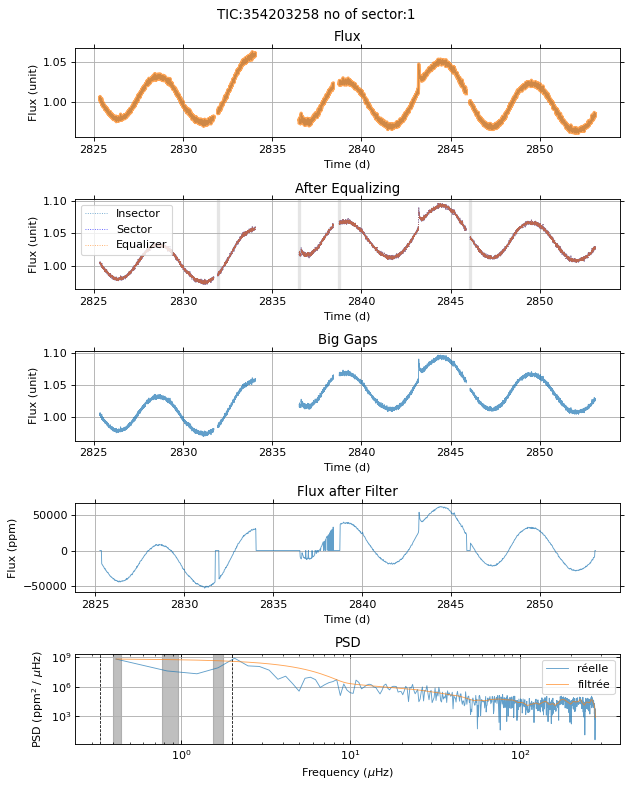

detected jump at time 1858.203506806028, threshold 4.304497792205891


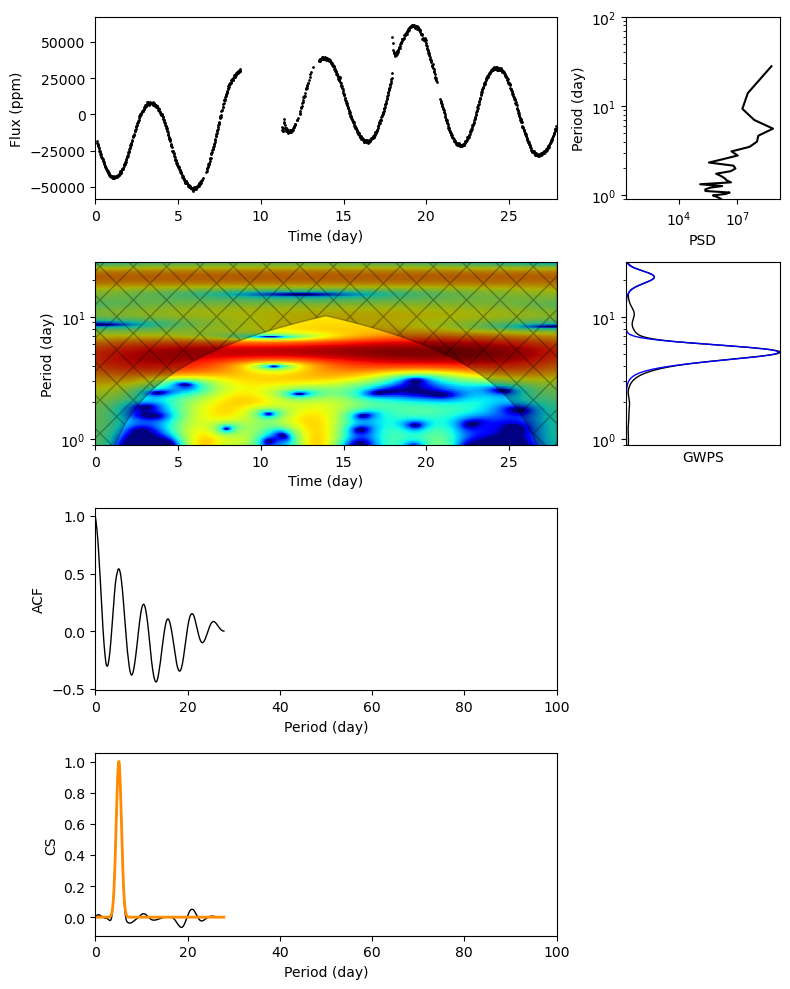

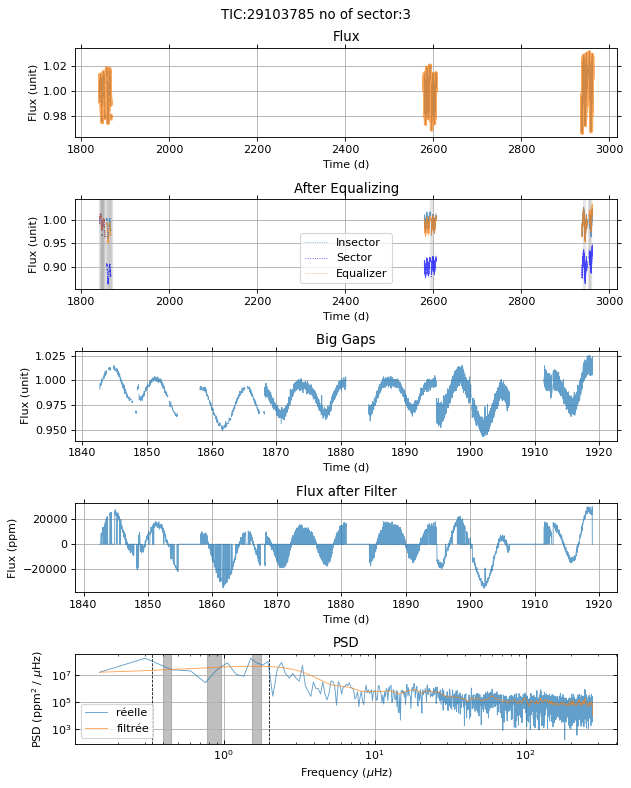

lightcurve was not correctly resampled before the PSD, result will be wrong
lightcurve was not correctly resampled before the PSD, result will be wrong


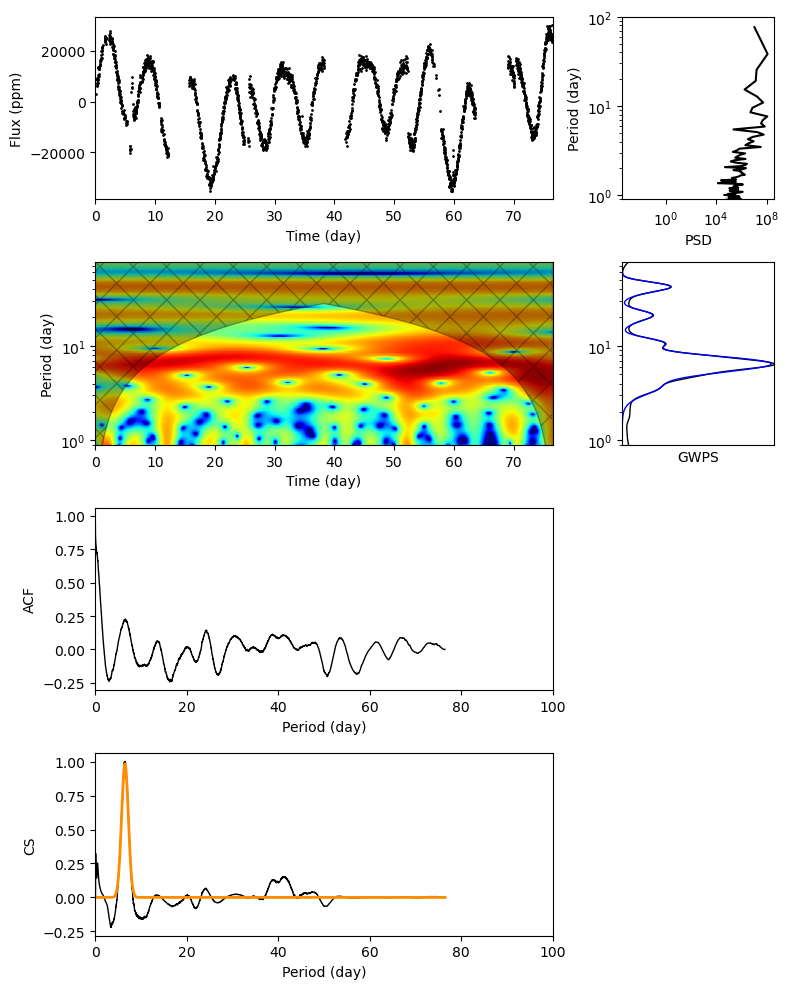

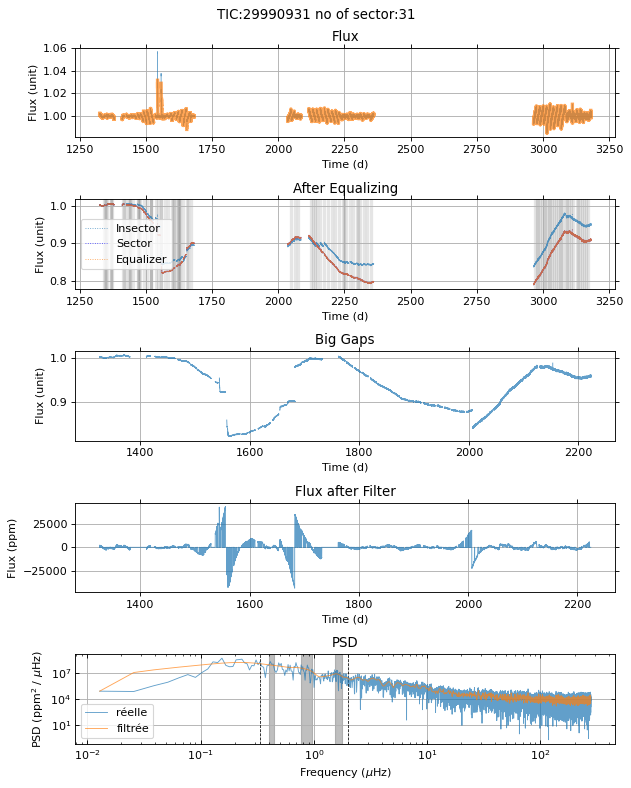

detected jump at time 1426.3238478200426, threshold 5.399760929762426
lightcurve was not correctly resampled before the PSD, result will be wrong
lightcurve was not correctly resampled before the PSD, result will be wrong


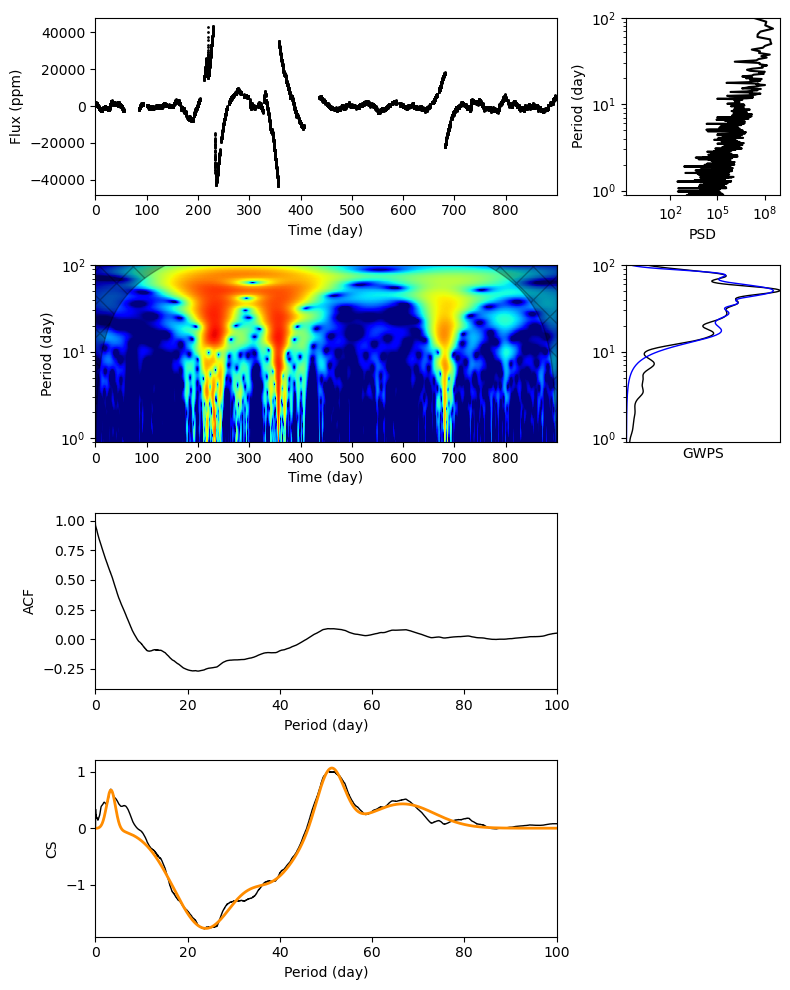

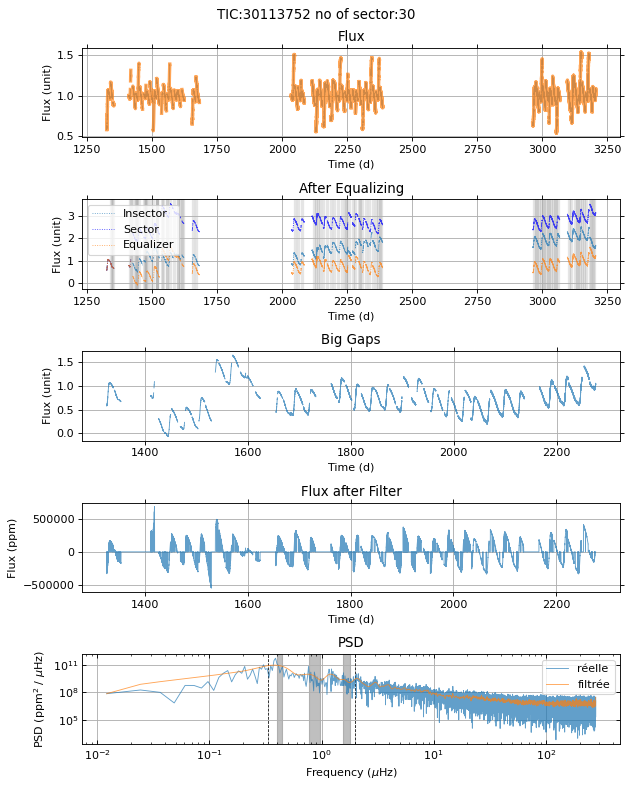

lightcurve was not correctly resampled before the PSD, result will be wrong
lightcurve was not correctly resampled before the PSD, result will be wrong


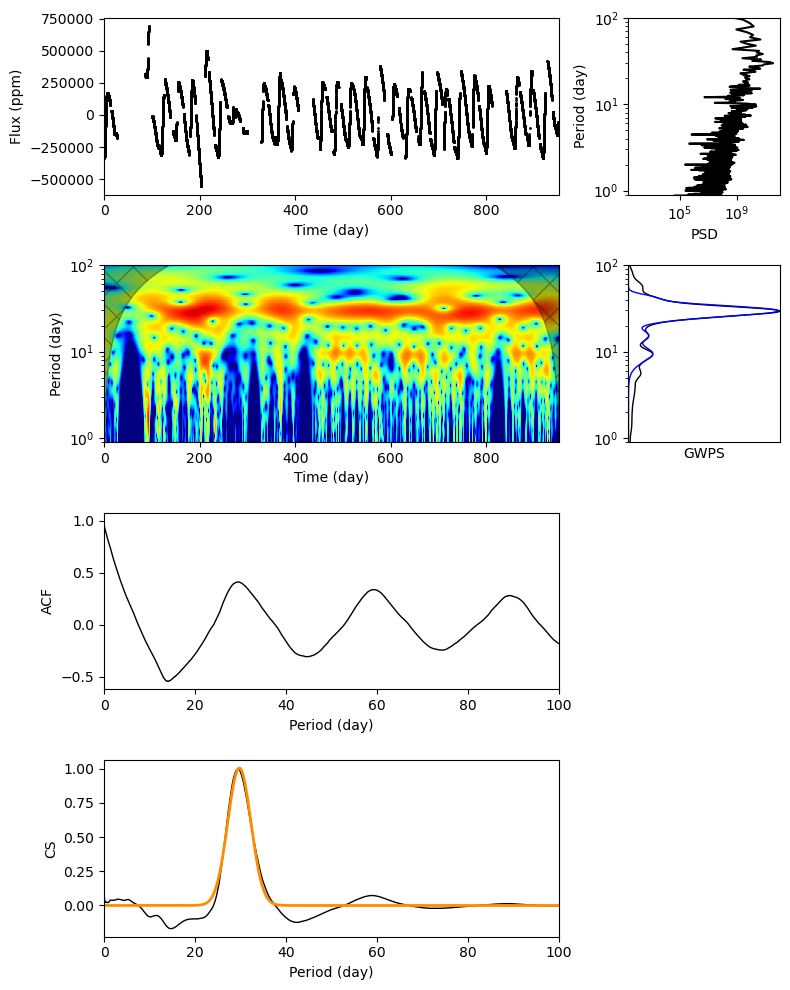

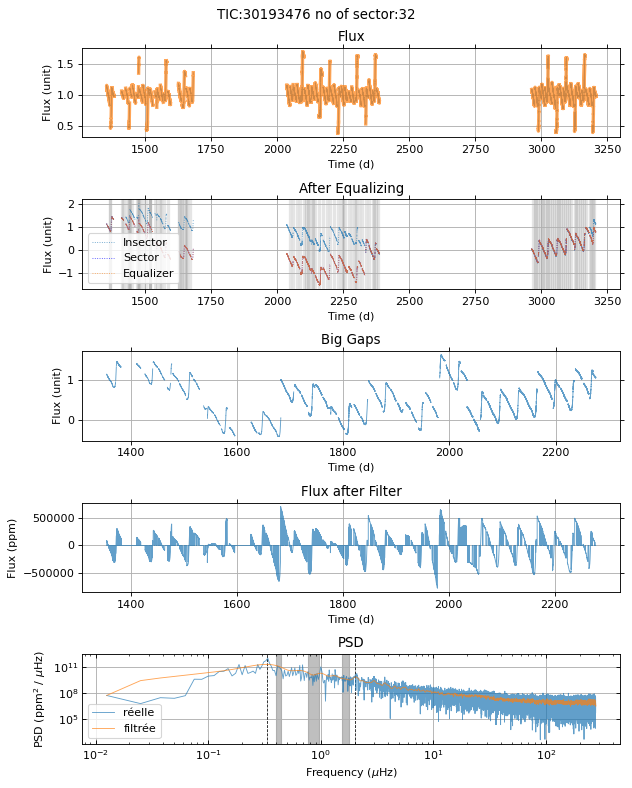

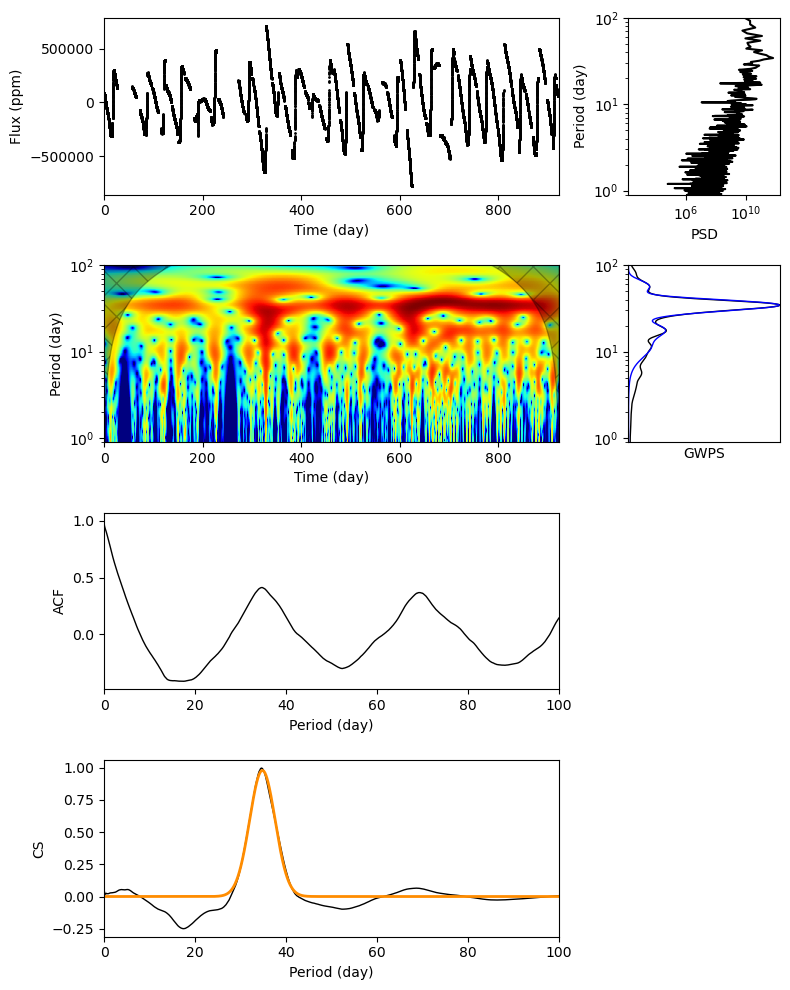

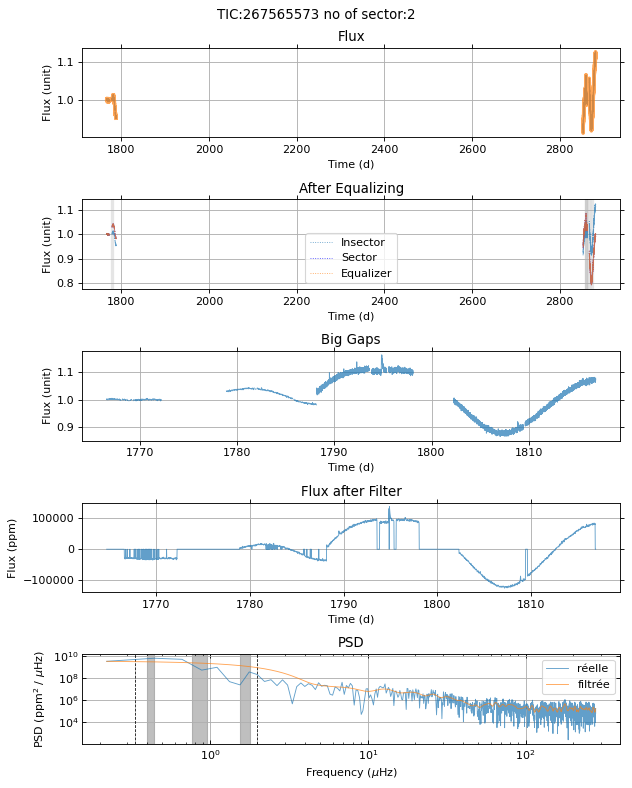

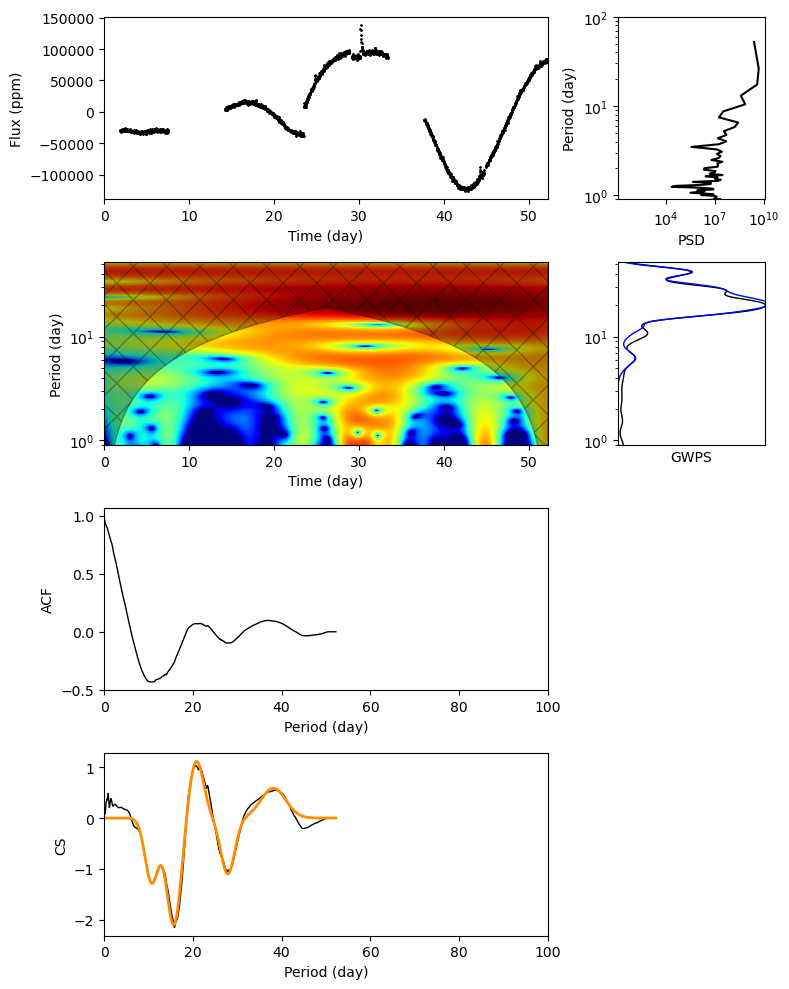

In [ ]:
test_TICs = [354203258, 29103785, 29990931, 30113752, 30193476, 267565573]
# test_TICs = [29103785]
plt.close("all")

data_loc_qlp = cat.load_data_location("local_dl_tess").file_location
for TIC_it in test_TICs:
    all_parameters = process_single_star_single_filter(
        TIC_it,
        data_loc_qlp=data_loc_qlp,
        path_name_out="./output_15thMay_correction_test_",
        filter_size_days=55,
        apply_filter=True,
        apply_big_gaps_removal=True,
        apply_equalization=True,
        starprivateer=True,
    )  # ,max_sector=27

## Multi core precessing

In [ ]:
import pandas as pd
from multiprocess import Pool
import os
from functools import partial
from tqdm import tqdm
import ipad
import numpy as np


def process_star(
    tic,
    flux_variable="SAP_FLUX",
    data_loc_qlp=None,
    filter_size_days=30,
    path_name_out="./output_15stMay_correction_",
):
    # print(f"Processing star with TIC: {tic}")
    all_parameters = process_single_star_single_filter(
        tic,
        flux_variable=flux_variable,
        filter_size_days=filter_size_days,
        data_loc_qlp=data_loc_qlp,
        path_name_out=path_name_out,
        apply_filter=True,
        apply_big_gaps_removal=True,
        apply_equalization=True,
        starprivateer=True,
    )
    # process_single_star_single_filter(tic, flux_variable=flux_variable,filter_size_days=filter_size_days,data_loc_qlp=data_loc_qlp,path_name_out = path_name_out)

    rotation_parameters = all_parameters["rotation_parameters"]
    combined_dict = {**rotation_parameters}
    return combined_dict


def run_multiprocessing(path_name_out="./output_15stMay_correction_"):
    # Parameters to modify:
    # ---------------------------

    filter_size_days = 55
    flux_variable = "SAP_FLUX"
    # ---------------------------
    # ---------------------------
    cat = ipad.catalog.Catalog()
    data_loc_qlp = cat.load_data_location("local_dl_tess").file_location

    dat_for_download = pd.read_parquet("Ohio_stars_for_analysis.parquet")
    list_tic_stars = list(
        dat_for_download.TIC.drop_duplicates().values
    )  # only 20 stars for testing
    list_tic_stars = np.concatenate((list_tic_stars[:244], list_tic_stars[245:]))
    # problem in star 244 -> TIC 267087558
    # list_tic_stars = list_tic_stars[245:]
    # Creating a pool with the default number of processes
    # Create a partial function that includes the fixed filter_size_days
    # flux_variable = 'SYS_RM_FLUX'
    print(path_name_out)
    partial_process_star = partial(
        process_star,
        flux_variable=flux_variable,
        filter_size_days=filter_size_days,
        data_loc_qlp=data_loc_qlp,
        path_name_out=path_name_out,
    )
    with Pool(processes=8) as pool:
        # Using imap_unordered to allow tqdm to show progress
        results = list(
            tqdm(
                pool.imap_unordered(partial_process_star, list_tic_stars), total=len(list_tic_stars)
            )
        )

    # Convert list of dictionaries to DataFrame
    features_df = pd.DataFrame(results)

    # Ensure the output directory exists
    output_dir = path_name_out + str(flux_variable) + "_" + str(filter_size_days) + "d/"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save to CSV
    features_df.to_csv(
        output_dir
        + "rotation_summary_"
        + str(flux_variable)
        + "_"
        + str(filter_size_days)
        + ".csv",
        index=False,
    )
    print("Completed processing all stars.")

In [ ]:
run_multiprocessing(path_name_out="./output_15thMay_correction_")

In [ ]:
for tic in list_tic_stars:
    try:
        # Open the images
        directory_10d = (
            "/Users/rgarcia/Projects/OHIO_BINARIES_PROT/output_1stMay_correction_SAP_FLUX_10d"
        )
        image1 = Image.open(directory_10d + "/figs/star_privateer/" + str(tic) + ".png")

        directory_20d = (
            "/Users/rgarcia/Projects/OHIO_BINARIES_PROT/output_1stMay_correction_SAP_FLUX_20d"
        )
        image2 = Image.open(directory_20d + "/figs/star_privateer/" + str(tic) + ".png")

        directory_60d = (
            "/Users/rgarcia/Projects/OHIO_BINARIES_PROT/output_1stMay_correction_SAP_FLUX_60d"
        )
        image3 = Image.open(directory_60d + "/figs/star_privateer/" + str(tic) + ".png")

        # Determine the desired width and height
        desired_width = min(
            image1.size[0], image2.size[0], image3.size[0]
        )  # Choose the smaller width
        desired_height = min(
            image1.size[1], image2.size[1], image3.size[1]
        )  # Choose the smaller height

        # Resize images
        image1 = image1.resize((desired_width, desired_height))
        image2 = image2.resize((desired_width, desired_height))
        image3 = image3.resize((desired_width, desired_height))

        # Create a new image with combined width and the desired height
        new_image = Image.new("RGB", (3 * desired_width, desired_height), (255, 255, 255))

        # Paste the images together
        new_image.paste(image1, (0, 0))
        new_image.paste(image2, (desired_width, 0))
        new_image.paste(
            image3, (2 * desired_width, 0)
        )  # Corrected pasting position for the third image

        # Save the new image
        combined_fig = "./combined_filter_figure/"
        os.makedirs(combined_fig, exist_ok=True)
        new_image.save(combined_fig + str(tic) + ".png")

    except Exception as e:
        print(f"Failed to process image for TIC {tic}: {e}")

In [ ]:
for tic in list_tic_stars:
    try:
        # Open the images
        directory_lobster_image = "/Users/rgarcia/Projects/OHIO_BINARIES_PROT/output_1stMay_correction_SAP_FLUX_60d"  # Update this with the directory of your fourth image
        image1 = Image.open(
            directory_lobster_image + "/figs/lobster_fig/" + str(tic) + ".png"
        )  # Update this with the path to your fourth image
        directory_10d = (
            "/Users/rgarcia/Projects/OHIO_BINARIES_PROT/output_1stMay_correction_SAP_FLUX_10d"
        )
        image2 = Image.open(directory_10d + "/figs/star_privateer/" + str(tic) + ".png")
        directory_20d = (
            "/Users/rgarcia/Projects/OHIO_BINARIES_PROT/output_1stMay_correction_SAP_FLUX_20d"
        )
        image3 = Image.open(directory_20d + "/figs/star_privateer/" + str(tic) + ".png")
        directory_60d = (
            "/Users/rgarcia/Projects/OHIO_BINARIES_PROT/output_1stMay_correction_SAP_FLUX_60d"
        )
        image4 = Image.open(directory_60d + "/figs/star_privateer/" + str(tic) + ".png")

        # Determine the desired width and height
        desired_width = min(
            image1.size[0], image2.size[0], image3.size[0], image4.size[0]
        )  # Choose the smallest width
        desired_height = min(
            image1.size[1], image2.size[1], image3.size[1], image4.size[1]
        )  # Choose the smallest height
        # Resize images
        image1 = image1.resize((desired_width, desired_height))
        image2 = image2.resize((desired_width, desired_height))
        image3 = image3.resize((desired_width, desired_height))
        image4 = image4.resize((desired_width, desired_height))  # Resize the fourth image
        # Create a new image with combined width and the desired height
        new_image = Image.new("RGB", (4 * desired_width, desired_height), (255, 255, 255))
        # Paste the images together
        new_image.paste(image1, (0, 0))
        new_image.paste(image2, (desired_width, 0))
        new_image.paste(image3, (2 * desired_width, 0))
        new_image.paste(
            image4, (3 * desired_width, 0)
        )  # Corrected pasting position for the fourth image
        # Save the new image
        combined_fig = "./combined_lobster_prot_filter_figure/"
        os.makedirs(combined_fig, exist_ok=True)
        new_image.save(combined_fig + str(tic) + ".png")
    except Exception as e:
        print(f"Failed to process image for TIC {tic}: {e}")

In [ ]:
# features_df

In [ ]:
# list_tic_stars=dat_for_download.TIC.unique()

# for tic in list_tic_stars[0:100]:
#     lis_of_files=ipad.downloads.qlp.get_star_list_of_fits_file(tic,dest_dir=data_loc_qlp)
#     source_df = ipad.io.reader.read_multiple_fits_files(lis_of_files).to_pandas()
#     source_df = source_df.sort_values('TIME')
#     source_df['SECTOR'] = source_df['SECTOR'].astype(int)
#     source_df = source_df.query('SECTOR > 55')
#     plt.figure()


#     for flux_variable in ['SYS_RM_FLUX','SAP_FLUX']:
#         time = source_df['TIME'].values
#         #flux = source_df['SYS_RM_FLUX'].values
#         flux = source_df[flux_variable].values
#         quality = source_df['QUALITY'].values
#         no_of_sector = len(source_df.SECTOR.unique())
#         color_dict = {'SYS_RM_FLUX':'blue', 'SAP_FLUX':'red'}
#         plt.scatter(time, flux, color=color_dict[flux_variable], s=1,label = flux_variable , alpha=0.2)
#         plt.ylim([0.4,1.5])

#     plt.legend()
#     plt.title('TIC '+str(tic) + ' Sectors'+ str(no_of_sector))
#     save_dir = './output_figures/'
#     os.makedirs(save_dir, exist_ok=True)
#     plt.savefig(save_dir+'TIC_'+str(tic)+'_Sectors_'+str(no_of_sector)+'.png')

In [ ]:
# source_df